# Add aerial and historic radar, and line2line radar interp



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm

from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points
import rasterio as rio

In [2]:
bed_gdf = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed_depth.shp')

In [3]:
def add_distance_to_gdf(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dx' and 'distance_cum' to the geodataframe
    """
    tmp_dfp = [Point.distance(gdf.geometry.iloc[i]) for i,Point in enumerate(gdf.geometry.iloc[1:])] #note the 1:, equivalent to i+1
    tmp_dfp[:0] = [0]
    gdf['dx'] = pd.Series(tmp_dfp) 
    gdf['distan_cum'] = gdf.dx.cumsum().copy()

In [5]:
ll = {} #a dictionary of geodataframes of radarlines over KIS2

for line in bed_gdf[bed_gdf.camp =='KIS2'].line_name.unique().tolist():
    ll[line] = bed_gdf[(bed_gdf.line_name==line) & (bed_gdf.camp=='KIS2')].reset_index(drop=True).copy()
    add_distance_to_gdf(ll[line])
gdf = bed_gdf[bed_gdf.camp =='KIS2'].copy()

In [38]:
nid1 = 159202
nid2 = 131226
df = gpd.read_file('/Users/home/whitefar/DATA/REMOTE_SENSING/REMA_2m_strips/REMA_Strip_Index_Rel1.shp')
path = f"/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_{nid1}-{nid2}_diff.tif"
f = df.loc[nid1].acquisitio
t =df.loc[nid2].acquisitio
duration = (pd.to_datetime(t)-pd.to_datetime(f)).days/365.25
with rio.open(path) as image:
    im = image.read(1)
    im[im==-9999] = np.nan
    im = im / duration
with rio.open('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/SETSM_WV01_20161109_1020010058134D00_10200100576C9100_seg1_2m_v1.0_dem.tif') as image:
    extent_REMA = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    im_REMA = image.read(1)/100

In [23]:
l2l_x = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2lineinterp_points_x.npy')
l2l_y = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2lineinterp_points_y.npy')
l2l_ice_thickn = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2lineinterp_ice_thickn.npy')

# First plot the line2line interpolated points

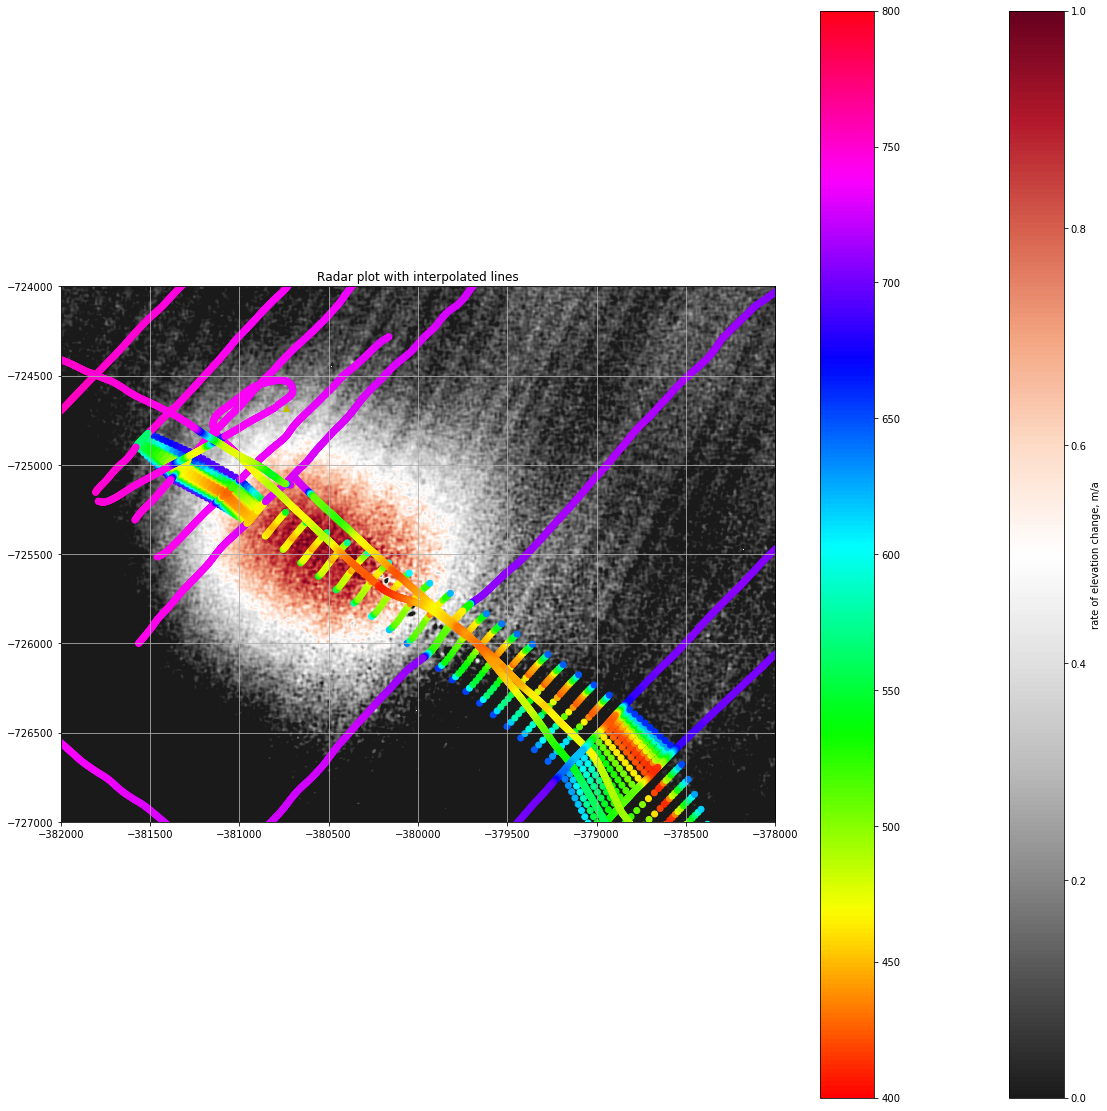

In [27]:
#rema
v=[0,1]    

extent = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
kis2 = [-380737.537026,-724683.311299]
plt.figure(figsize=(20,20))
GyRd = plt.cm.get_cmap('RdGy').reversed()
plt.imshow(im,extent=extent, vmin=v[0],vmax=v[1],cmap=GyRd)
cb = plt.colorbar()
plt.plot(kis2[0],kis2[1],'y^')
cb.set_label('rate of elevation change, m/a')

# radar
plt.scatter( l2l_x,l2l_y,c=l2l_ice_thickn,cmap='hsv',vmin=400, vmax=800)
plt.scatter( gdf.x,gdf.y,c=gdf.ice_thickn,cmap='hsv',vmin=400, vmax=800)

plt.colorbar()
plt.title('Radar plot with interpolated lines')
plt.xlim([-382000, -378000])
plt.ylim([-727000,-724000])
plt.grid()
plt.show()

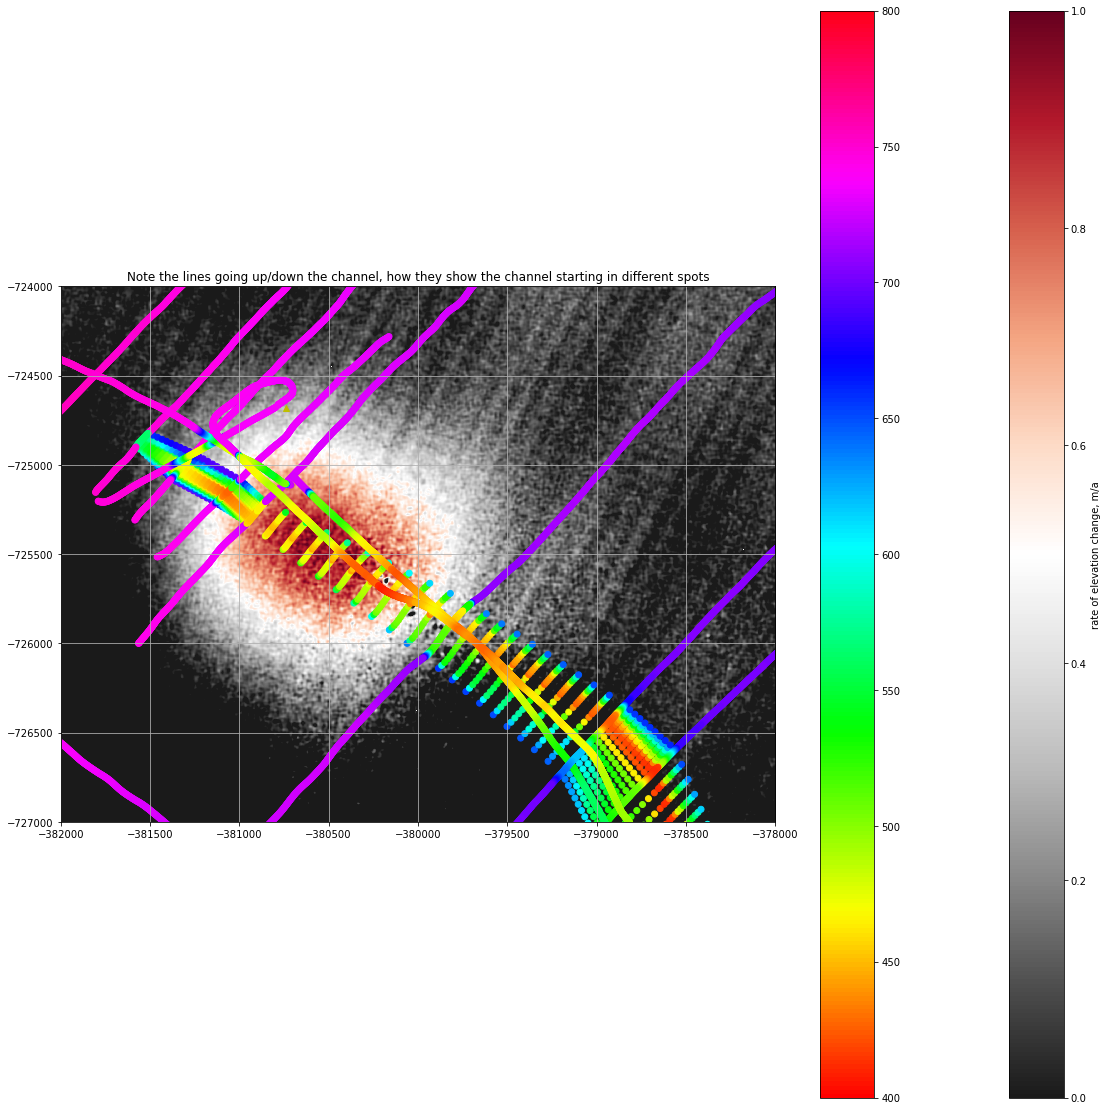

In [37]:
#rema
v=[0,1]    

extent = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
kis2 = [-380737.537026,-724683.311299]
plt.figure(figsize=(20,20))
GyRd = plt.cm.get_cmap('RdGy').reversed()
plt.imshow(im,extent=extent, vmin=v[0],vmax=v[1],cmap=GyRd)
cb = plt.colorbar()
plt.plot(kis2[0],kis2[1],'y^')
cb.set_label('rate of elevation change, m/a')

# radar
plt.scatter( l2l_x,l2l_y,c=l2l_ice_thickn,cmap='hsv',vmin=400, vmax=800)
plt.scatter( gdf.x,gdf.y,c=gdf.ice_thickn,cmap='hsv',vmin=400, vmax=800)
plt.scatter( gdf.query('line_name=="lineAPRESdown"').x,gdf.query('line_name=="lineAPRESdown"').y,
            c=gdf.query('line_name=="lineAPRESdown"').ice_thickn,cmap='hsv',vmin=400, vmax=800)

plt.colorbar()
plt.title('Note the lines going up/down the channel, how they show the channel starting in different spots')
plt.xlim([-382000, -378000])
plt.ylim([-727000,-724000])
plt.grid()
plt.show()

### to look up:

lineAPRESdown lineupchan and linedownchan. How does the channel start and is it relared to the stratening of the antenna

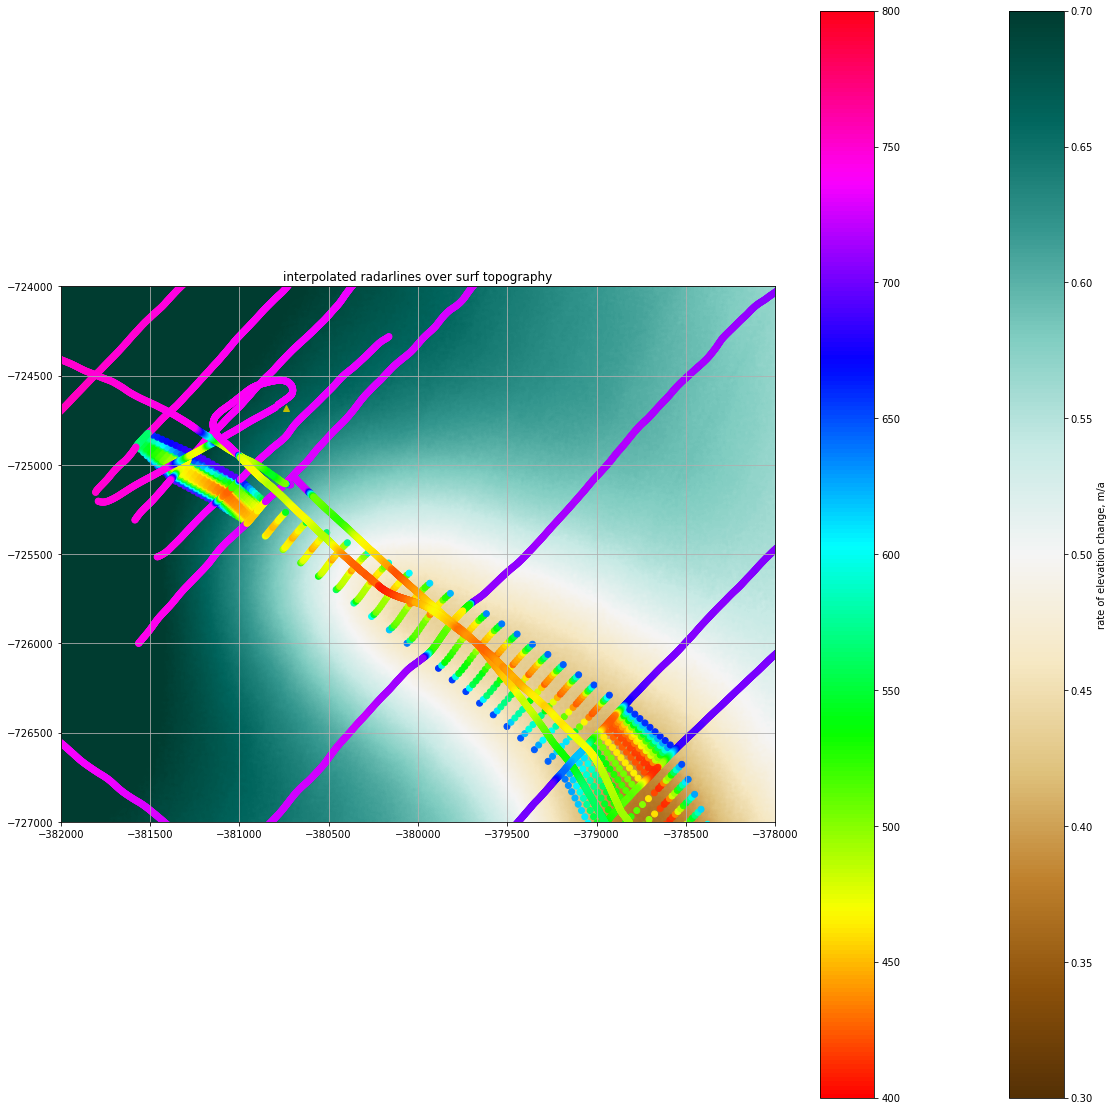

In [40]:
#rema
v=[0,1]    

extent = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
kis2 = [-380737.537026,-724683.311299]
plt.figure(figsize=(20,20))
plt.imshow(im_REMA,extent=extent_REMA,vmin=0.3,vmax=0.7, cmap='BrBG')
cb = plt.colorbar()
cb.set_label('surface elevation (?)')
plt.plot(kis2[0],kis2[1],'y^')
cb.set_label('rate of elevation change, m/a')

# radar
plt.scatter( l2l_x,l2l_y,c=l2l_ice_thickn,cmap='hsv',vmin=400, vmax=800)
plt.scatter( gdf.x,gdf.y,c=gdf.ice_thickn,cmap='hsv',vmin=400, vmax=800)
plt.scatter( gdf.query('line_name=="lineAPRESdown"').x,gdf.query('line_name=="lineAPRESdown"').y,
            c=gdf.query('line_name=="lineAPRESdown"').ice_thickn,cmap='hsv',vmin=400, vmax=800)

plt.colorbar()
plt.title('interpolated radarlines over surf topography')
plt.xlim([-382000, -378000])
plt.ylim([-727000,-724000])
plt.grid()
plt.show()

# Add the other historic radar lines

In [52]:
gdf_hist = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/cresisplus1516Channel.shp').rename(columns={'field_1':'x','field_2':'y','field_3':'surf','field_4':'bed'})

In [55]:

xmin =-385000
xmax = -374000
ymin = -735000
ymax = -720000
gdf_hist.query(f'(x > {xmax}) & (x < {xmin}) & (y > {ymax} )& (y < {ymin})')

AttributeError: 'UnaryOp' object has no attribute 'evaluate'

In [ ]:
#rema
v=[0,1]    

extent = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
kis2 = [-380737.537026,-724683.311299]
plt.figure(figsize=(20,20))
plt.imshow(im_REMA,extent=extent_REMA,vmin=0.3,vmax=0.7, cmap='BrBG')
cb = plt.colorbar()
cb.set_label('surface elevation (?)')
plt.plot(kis2[0],kis2[1],'y^')
cb.set_label('rate of elevation change, m/a')

# radar
# plt.scatter( gdf.x,gdf.y,c=gdf.ice_thickn,cmap='hsv',vmin=400, vmax=800)

plt.scatter(gdf_hist.x,gdf_hist.y,c=gdf_hist.bed,cmap='hsv')


plt.colorbar()
plt.title('interpolated radarlines over surf topography')
plt.xlim([-382000, -378000])
plt.ylim([-727000,-724000])
plt.grid()
plt.show()

In [28]:
with rio.open('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/SETSM_WV01_20161109_1020010058134D00_10200100576C9100_seg1_2m_v1.0_dem.tif') as image:
    extent_REMA = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    im_REMA = image.read(1)/100